In [1]:
%matplotlib inline
#
from os import chdir, getcwd
ROOTF = 'LRG-Signed'
if getcwd()[-len(ROOTF):] != ROOTF:
    chdir('../')
print('cwd:', getcwd())
#
from src.LRGSG_package.LRGSG import *

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


In [2]:
theLattice = Lattice2D(#
    side1 = 10,
    geometry = 'hexagonal',
)

In [4]:
theLattice.side1

17

In [138]:
#Generate network
L = 50
p = 0.2
G = nx.grid_2d_graph(L, L, periodic=True)
flip_random_fract_edges(G, p)
neg_weightsG = {((i, j), (i, j+1)): -1 for i in range(L) for j in [L//3, L//2]}#strip
# neg_weightsG = {(i[0], i[1]): -1 for i in list(G.edges())[::2]}
# neg_weightsG = {((i, j), (i+1, j)): -1 for i in range(L) for j in range(L//2, L//2+4)}
# nx.set_edge_attributes(G, values=1, name='weight')
# nx.set_edge_attributes(G, values=neg_weightsG, name='weight')
#
N=G.number_of_nodes()

#
H = nx.convert_node_labels_to_integers(G)

In [139]:
adj = nx.adjacency_matrix(G).toarray()
diabs = np.diag(np.abs(adj).sum(axis=1))
slapl = diabs - adj
eigv, eigV = np.linalg.eigh(slapl)
eigV=np.transpose(eigV)

In [140]:
labels=np.where((eigV[0] < 0))[0]
lista=['red' if i in labels else 'blue' for i in range(H.number_of_nodes())]
listaE=['red' if e[2]['weight']==-1 else 'blue' for e in list(H.edges(data=True))]
pos = dict((i, n) for i,n in enumerate(G.nodes()))

In [211]:
#
nmax=2*N
T=0.08

def calcEnergy(m, H):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(N):
        neigh=[w['weight']*m[nn] for nn, w in dict(H[i]).items()]
        energy += -m[i]*np.sum(neigh)
    return energy/4.

#Initialize magnetization
labels=np.where((eigV[0] < 0))[0]
lista=['k' if i in labels else 'w' for i in range(H.number_of_nodes())]
bigene = []
INIT = 'eigenSquare+rand'
for replica in range(1):
    if INIT == 'eigenvalue':
        m=[1 if i in labels else -1 for i in range(H.number_of_nodes())]
    elif INIT == 'eigenSquare+rand':
        m=np.array([1 if i in labels else -1 for i in range(H.number_of_nodes())])
        height_s = L//4
        height_e = 3*L//4
        square_indices = np.concatenate([[j+i*L for j in range(height_s, height_e)] for i in range(height_s, height_e)])
        all_incides = np.arange(N)
        out_indices = np.setxor1d(all_incides, square_indices)
        m[out_indices] = np.random.choice([-1,1],size=len(out_indices))
    elif INIT == 'rand':
        m=np.random.choice([-1,1],size=N)
    #Metropolis
    magn = []
    ene = []
    sample = random.sample(H.nodes, N)
    for nsteps in tqdm(range(nmax)):
        magn.append(np.sum(m))
        ene.append(calcEnergy(m, H))
        for i in range(N):
            node=sample[i]
            m_new = -m[node]

            #Metropolis thing
            neigh=[w['weight']*m[nn] for nn, w in dict(H[node]).items()]
            E_old=-m[node]*np.sum(neigh)
            E_new=-m_new*np.sum(neigh)

            if E_new<E_old:
                m[node]=m_new
            else:
                r=random.uniform(0, 1)
                if (r<np.exp(-(E_new-E_old)/T)):
                    m[node]=m_new
    bigene.append(ene)

/tmp/ipykernel_7629/938473210.py:34: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(H.nodes, N)
  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [04:09<00:00, 20.04it/s]


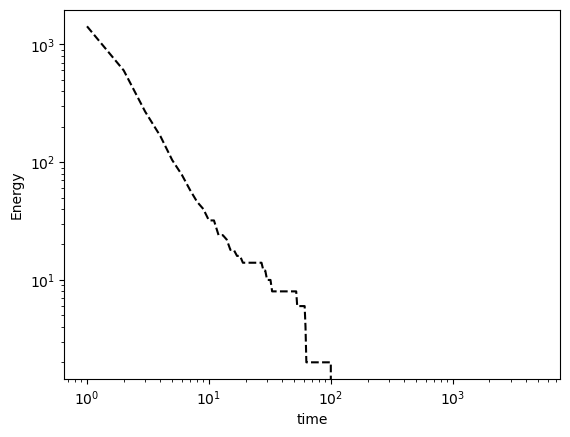

In [202]:
# for i in range(19):
#     plt.plot(np.linspace(1, len(bigene[i]), num=len(bigene[i])), bigene[i]+ np.max(np.abs(bigene[-1])))
plt.plot(np.linspace(1, len(bigene[-1]), num=len(bigene[-1])), bigene[-1] + np.max(np.abs(bigene[-1])), c='k', ls='--')
plt.xscale('log')
plt.ylabel('Energy')
plt.xlabel('time')
# plt.ylim([1,1e3])
# 
plt.yscale('log')

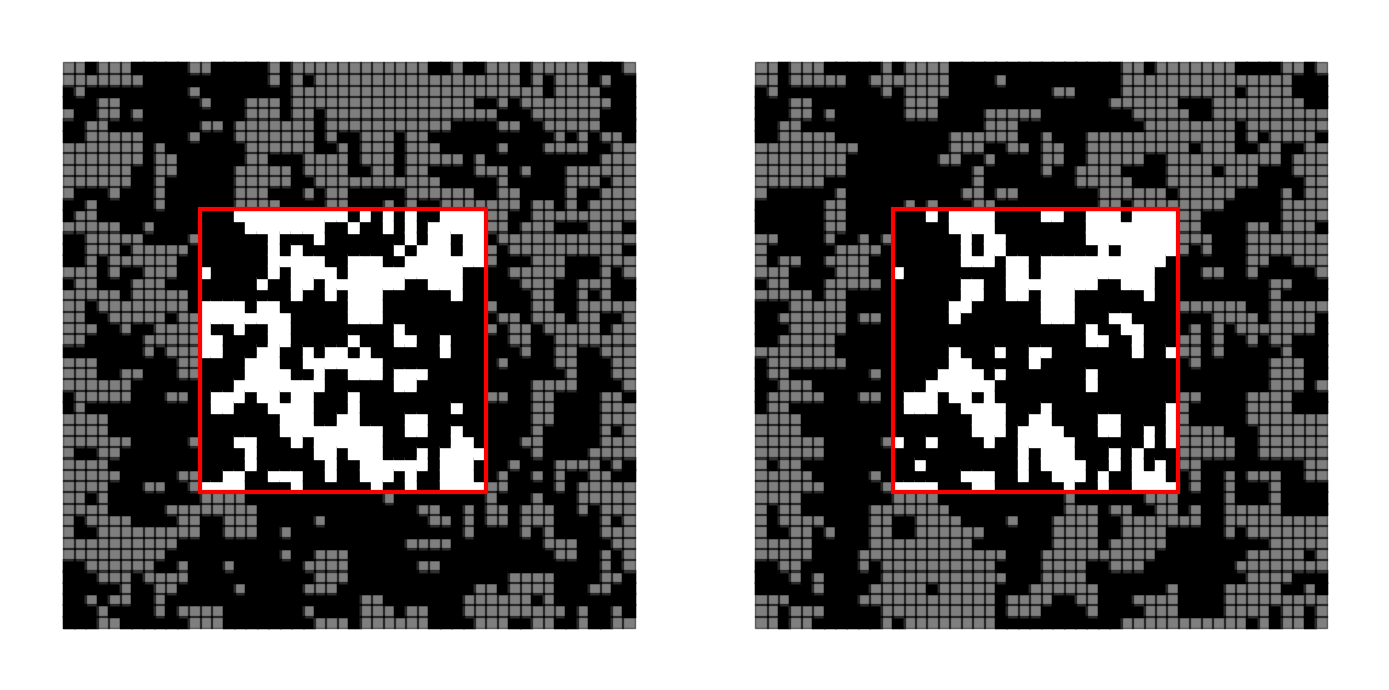

In [212]:
mapping = {old_label:new_label 
           for new_label, old_label in enumerate(G.nodes())}
Im=np.zeros((L,L))
for i1 in range(N):
    Node=list(mapping)[i1]
    if ((m[i1])==1): 
        Im[Node[1], Node[0]]=-1
    if ((m[i1])==-1): 
        Im[Node[1],Node[0]]=1


listam=['k' if i >0 else 'w' for i in m]
listam2=[(0, 0, 0, .5) if i in out_indices else e for i,e in enumerate(listam)]
lista2=[(0, 0, 0, .5) if i in out_indices else e for i,e in enumerate(lista)]

def keydict_nxdraw_lapleig(pos, ax, node_color='red', node_size=80, node_shape="s", ):
    return locals()

# cmap = colors.ListedColormap(['darkblue', 'red'])
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(14, 7))
#
#
nx.draw(H, **keydict_nxdraw_lapleig(pos, ax, lista))
nx.draw(H, **keydict_nxdraw_lapleig(pos, ax, lista2))
rect = Rectangle((L//4-.5,L//4-.5),L//2, L//2, color='red', alpha=1, fill=False, lw=3, zorder=2)
ax.add_patch(rect)
#
#
nx.draw(H, **keydict_nxdraw_lapleig(pos, ax1, listam))
nx.draw(H, **keydict_nxdraw_lapleig(pos, ax1, listam2))
rect = Rectangle((L//4-.5,L//4-.5),L//2, L//2, color='red', alpha=1, fill=False, lw=3, zorder=2)
ax1.add_patch(rect)
# im = ax1.imshow(Im,interpolation=None,cmap=cmap, origin='lower')
# fig.colorbar(im, ax=ax1)
plt.subplots_adjust(wspace=None)
fig.tight_layout()

In [215]:
G = nx.grid_2d_graph(10, 10, periodic=True)
posG = dict(zip(G, G))
nx.set_node_attributes(G, values=posG, name='pos')
H = nx.convert_node_labels_to_integers(G)

In [213]:
l = np.array(lista)
lm = np.array(listam)

autolap = l == 'k'
autonag = lm == 'k'

square_overlap = boolean_overlap_fraction(autolap[square_indices], autonag[square_indices])
external_overlap = boolean_overlap_fraction(autolap[out_indices], autonag[out_indices])
total_overlap = boolean_overlap_fraction(autolap, autonag)

square_overlap, external_overlap, total_overlap

(0.8064, 0.5488, 0.6132)

In [209]:
(lista == listam)

False

In [2]:
#Generate network
L = 20
p = 0.12
G = nx.grid_2d_graph(L, L, periodic=True)
flip_random_fract_edges(G, p)
neg_weightsG = {((i, j), (i, j+1)): -1 for i in range(L) for j in [L//3, L//2]}#strip
# neg_weightsG = {(i[0], i[1]): -1 for i in list(G.edges())[::2]}
# neg_weightsG = {((i, j), (i+1, j)): -1 for i in range(L) for j in range(L//2, L//2+4)}
# nx.set_edge_attributes(G, values=1, name='weight')
# nx.set_edge_attributes(G, values=neg_weightsG, name='weight')
#
N=G.number_of_nodes()

#
H = nx.convert_node_labels_to_integers(G)


In [3]:
adj = nx.adjacency_matrix(G).toarray()
diabs = np.diag(np.abs(adj).sum(axis=1))
slapl = diabs - adj
eigv, eigV = np.linalg.eigh(slapl)
eigV=np.transpose(eigV)

In [4]:
labels=np.where((eigV[0] < 0))[0]
lista=['red' if i in labels else 'blue' for i in range(H.number_of_nodes())]
listaE=['red' if e[2]['weight'] < 0 else 'blue' for e in list(H.edges(data=True))]
pos = dict((i, n) for i,n in enumerate(G.nodes()))

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import sys
import random as rd
import numpy as np
from tqdm import tqdm

#
nmax=2*N
T=0.1

def calcEnergy(m, H):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(N):
        neigh=[w['weight']*m[nn] for nn, w in dict(H[i]).items()]
        energy += -m[i]*np.sum(neigh)
    return energy/4.

#Initialize magnetization
labels=np.where((eigV[0] < 0))[0]
lista=['red' if i in labels else 'blue' for i in range(H.number_of_nodes())]

m=[1 if i in labels else -1 for i in range(H.number_of_nodes())]

#Metropolis
magn = []
ene = []
sample = rd.sample(H.nodes, N)
for nsteps in tqdm(range(nmax)):
    magn.append(np.sum(m))
    ene.append(calcEnergy(m, H))
    for i in range(N):
        node=sample[i]
        m_new = -m[node]

        #Metropolis thing
        neigh=[w['weight']*m[nn] for nn, w in dict(H[node]).items()]
        E_old=-m[node]*np.sum(neigh)
        E_new=-m_new*np.sum(neigh)

        if E_new<E_old:
            m[node]=m_new
        else:
            r=rd.uniform(0, 1)
            if (r<np.exp(-(E_new-E_old)/T)):
                m[node]=m_new


/tmp/ipykernel_6332/3190446764.py:29: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = rd.sample(H.nodes, N)
100%|██████████| 800/800 [00:05<00:00, 135.87it/s]


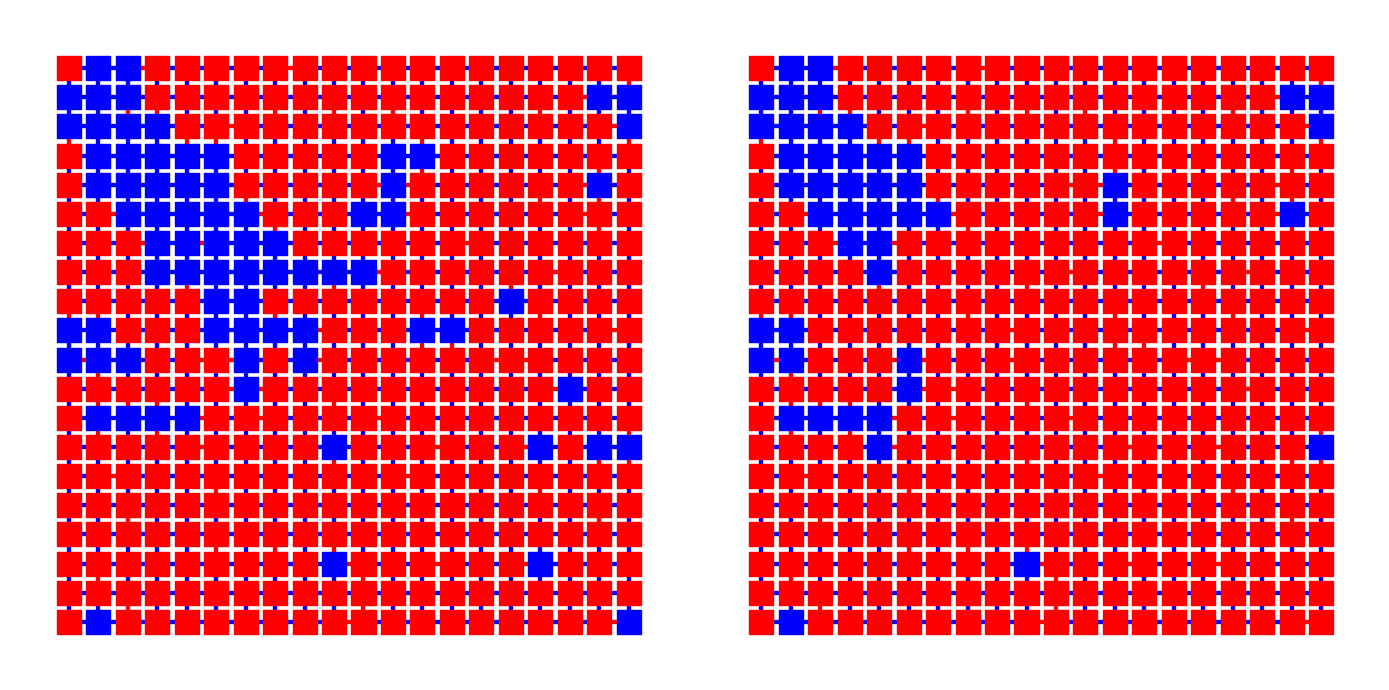

In [6]:
mapping = {old_label:new_label for new_label, old_label in enumerate(G.nodes())}
Im=np.zeros((L,L))
for i1 in range(N):
    Node=list(mapping)[i1]
    if ((m[i1])==1): 
        Im[Node[1], Node[0]]=-1
    if ((m[i1])==-1): 
        Im[Node[1],Node[0]]=1


listam=['red' if i >0 else 'blue' for i in m]
from matplotlib import colors
# cmap = colors.ListedColormap(['darkblue', 'red'])
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(14, 7))
plt.subplots_adjust(wspace=None)
nx.draw(H, pos=pos, node_size=300, width=3, ax=ax, node_color=lista, node_shape="s", edge_color=listaE)
nx.draw(H, pos=pos, node_size=300, width=3, ax=ax1, node_color=listam, node_shape="s", edge_color=listaE)
# im = ax1.imshow(Im,interpolation=None,cmap=cmap, origin='lower')
# fig.colorbar(im, ax=ax1)
fig.tight_layout()